In [1]:
%matplotlib inline
#%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg
import scipy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
#from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, date2num, num2date
from load_gridded_data import read_gridded_data_CMIP5_model
from gridAvg import gridAvg
import wd

In [2]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [198]:
# Load various model output and interpolate to CCSM4 resolution

# CHANGE THIS TO USE THE SAME SORT OF STRUCTURE THAT dd is!

from scipy import interpolate
import gridAvg

data_dir = '/Users/dan/Desktop/CCSM4_ctrl/'
data_files = ['HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc',
              'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
              'MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc']
model_names = ['HadCM3','CCSM4','MPI-ESM']
data_vars = {'tas_sfc_Amon':0}

outtimeavg = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
time = np.arange(850,1851)

ad = []

Ldf = len(data_files)

for ii in np.arange(Ldf):
#for ii in np.array([1]):
    
    data_file = data_files[ii]
    ny = 1000
    dd=read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
    dd['model_name'] = model_names[ii]

    if ii==0:
        dd['datam'] = np.reshape(dd['tas_sfc_Amon']['value'][:ny,:,:],[ny,-1]).transpose()
        #dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],1),[min(dd['datam'].shape),1]).T

    # If not the model whose grid we're using, interpolate to that grid.
    if ii!=0:
        x    = dd['tas_sfc_Amon']['lon']
        y    = dd['tas_sfc_Amon']['lat']
#        xx, yy = np.meshgrid(x,y)
        xnew = ad[0]['tas_sfc_Amon']['lon']
        ynew = ad[0]['tas_sfc_Amon']['lat']
        umhr = np.zeros(ad[0]['data'].shape)

        for jj in np.arange(ny):
            f = scipy.interpolate.RectBivariateSpline(y,x,dd['tas_sfc_Amon']['value'][jj,:,:].reshape(len(y),len(x)))
            umhr[:,jj] = f(ynew, xnew).ravel()

            
# Made some changes to get the dimensions consistent but haven't checked that anomalies make sense, so could be an error here!            
            
        dd['datam'] = umhr
        dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],1),[min(dd['datam'].shape),1]).T
        dd['tas_sfc_Amon']['lat'] = ad[0]['tas_sfc_Amon']['lat']
        dd['tas_sfc_Amon']['lon'] = ad[0]['tas_sfc_Amon']['lon']

    ad.append(dd)



Reading file:  /Users/dan/Desktop/CCSM4_ctrl//HadCM3/tas_sfc_Amon_HadCM3_past1000_085001-185012.nc
(12012, 73, 96)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= -3.075072e-07  , std-dev= 1.996391
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= -2.700413205941557e-07  , std-dev= 0.8439147355739832
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//MPI/tas_sfc_Amon_MPI-ESM-P_past1000_085001-185012.nc
(12000, 96, 192)
Anomalies provided as the prior: Removing 

In [53]:
## Make a gridded average of normalized proxy data to use as a mask on the CCSM4 output
proxy_pandas_metafile = 'Pages2k_Metadata.df.pckl'
proxy_pandas_datafile = 'Pages2k_Proxies.df.pckl'

proxy_meta = pandas.read_pickle(proxy_pandas_metafile)
proxy_data = pandas.read_pickle(proxy_pandas_datafile)

# necessary to index this as I'd like. not sure why...
proxy_data.index=proxy_data.index.astype('float64')
proxy_data = proxy_data.astype('float64')

proxy_data = proxy_data[0:2011]

# Reformat the proxy_meta to get rid of special characters
proxy_meta.columns = [x.strip().replace(' ','_') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('(','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace(')','') for x in proxy_meta.columns]
proxy_meta.columns = [x.strip().replace('.','') for x in proxy_meta.columns]

# Change the metadata file so that indices are NCDC IDs (better matchup with data file)
proxy_meta.index = proxy_meta['PAGES_ID']
proxy_meta=proxy_meta.rename(columns = {'PAGES_ID':'NCDC_ID'})

# Replace all proxy types with a placeholder for now

proxy_meta['Archive_type'] = proxy_meta['Archive_type'].str.replace(' ','_')

# sort the metadata to have the same order as the data file
proxy_data = proxy_data.loc[:,proxy_meta.index]

# Remove one record that has a range of lat-lon values
proxy_data = proxy_data.drop('Eur_11',1)
proxy_meta = proxy_meta.drop('Eur_11',0)

proxy_data = proxy_data.dropna(1,'all')
proxy_meta = proxy_meta.loc[proxy_data.columns]

proxy_meta.loc[:,'Lat_N'] = proxy_meta.loc[:,'Lat_N'].astype('float64')
proxy_meta.loc[:,'Lon_E'] = proxy_meta.loc[:,'Lon_E'].astype('float64')

import gridAvg
reload( gridAvg )
from gridAvg import gridAvg
# For some reason lon goes from 0 to 359. but lat goes from -90 to 90. I'm treating it instead like it's going from -90 to 89...
xRes = 360. / len(ad[0]['tas_sfc_Amon']['lon'])
yRes = 180. / (len(ad[0]['tas_sfc_Amon']['lat']))

gridded, pmg, lat_g,lon_g, Gn = gridAvg(proxy_meta,proxy_data,xRes,yRes)

# Make a mask from the data
# dmask = (np.nansum(gridded,0)!=0)

In [157]:
# Compare what happens for various truth-prior pairs

import wd; reload(wd)

# Array of dictionaries containing the different comparisons
cd = []

# Set proxy locations equal to the PAGES2k network sites. Since there is no observational noise,
# having additional obs makes no difference, so just one per gridbox with any number of proxies
# MASK  = dmask
# L = np.size(dmask)

L = np.size(Gn)

# Make a vector of 
inds = np.arange(Gn.shape[0]*Gn.shape[1])
list = []

## New code that allows for multiple obs at a gridpoint. lt is a list of indices (C-indexed) corresponding to data locations.
# Loop through Gn. 
# When it (Gn[jj]) is nonzero, grab the index and make a vector of Gn[jj] values of that index.
# Concatenate that vector onto the list that we're interested in.
lt = []
for ii in inds[Gn.ravel()!=0]:
    lt = np.concatenate([lt,ii*np.ones(Gn.ravel()[ii].astype(int))]).astype(int)

# Make the H (data) matrix
H = np.eye(L)[lt,:]

rpt_p2k = np.zeros([Ldf,Ldf,L,1000])
rpt_all = np.zeros([Ldf,Ldf,L,1000])

for ii in np.arange(len(data_files)):

    prior = ad[ii]['data']
    #hbhi = scipy.linalg.pinv(np.linalg.multi_dot([H,prior,prior.T,H.T]))
    #bi = scipy.linalg.pinv(np.linalg.multi_dot([prior,prior.T]))

    
    # No noise case    
    hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

    # SNR = 1 case
    # Generate vector of error standard deviations based on a fixed SNR
    SNR = .0001
    globalStds = np.std(prior,1).ravel()
    sigs = globalStds[lt]*1./SNR
    hbhi_1 = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)) + np.diag(sigs**2),rcond=1 )

    # For a complete observing system, it's BB^{-1}. I want to save this i.t.o. its factors. 
    # Probably easiest to do with SVD. 
    # Just UU.T
    u = np.linalg.svd(prior,full_matrices=False)[0]

    for jj in np.arange(len(data_files)):

        truth = ad[jj]['data']
        
        # These "filtered truth" variables are the posterior estimate.
        # Filtered truth ensemble using PAGES2k data distribution
        fp = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,truth])

        # Filtered truth ensemble using PAGES2k data distribution and SNR = 1
        fp_1 = np.linalg.multi_dot([prior,prior.T,H.T,hbhi_1,H,truth])
        
        # Filtered truth ensemble using complete data distribution
        fc = np.linalg.multi_dot([u,u.T,truth])

        # Define cosine weights for the EOFs
        lon_m,lat_m = np.meshgrid(ad[0]['tas_sfc_Amon']['lon'],ad[0]['tas_sfc_Amon']['lat'])
        coswts = np.sqrt(np.cos(lat_m.ravel()*np.pi/180))
        
        # Eigenvectors of the nullspace uncertainty
        ufp,sfp,tmp = np.linalg.svd(np.tile(coswts,(1000,1)).T*(truth-fp),full_matrices=False)
        ufc,sfc,tmp = np.linalg.svd(np.tile(coswts,(1000,1)).T*(truth-fc),full_matrices=False)
        
        # Eigenvectors of the posterior covariance in the no-noise case. I do not do any area weighting
        # because of how these are used later.
        uPp,sPp,tmp = np.linalg.svd(prior-fp,full_matrices=False)
        uPc,sPc,tmp = np.linalg.svd(prior-truth-fc,full_matrices=False)

        print(model_names[ii])
        print(model_names[jj])
        
        # Store this information in a dictionary
        c = {}
        c['Prior_name'] = model_names[ii]
        c['Prior'] = prior
        c['Pind'] = ii
        c['Truth_name'] = model_names[jj]
        c['Truth'] = truth
        c['Tind'] = jj
        c['Filtered truth ensemble using PAGES2k'] = fp
        c['Filtered truth ensemble using PAGES2k with SNR = 1'] = fp_1
        c['Filtered truth ensemble using complete obs'] = fc

        c['Eigenvectors of nullspace unc using PAGES2k'] = ufp
        c['Eigenvectors of nullspace unc using complete obs'] = ufc
        c['Eigenvalues of nullspace unc using PAGES2k'] = sfp
        c['Eigenvalues of nullspace unc using complete obs'] = sfc

        c['Eigenvectors of posterior cov using PAGES2k'] = uPp
        c['Eigenvectors of posterior cov using complete obs'] = uPc
        c['Eigenvalues of posterior cov using PAGES2k'] = sPp
        c['Eigenvalues of posterior cov using complete obs'] = sPc

        c['RMS global mean difference using complete obs'] = np.mean((np.mean(truth,0)-np.mean(fc,0))**2)**.5
        c['RMS global mean difference using PAGES2k'] = np.mean((np.mean(truth,0)-np.mean(fp,0))**2)**.5
        
        #wd.plotMap_nl(lon_g,lat_g,sfp[0]*ufp[:,0].reshape(len(lat_g),len(lon_g)),'')

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs
        cd.append(c)
        
        
#np.save('prior-truth-comp',cd)

HadCM3
HadCM3
HadCM3
CCSM4
HadCM3
MPI-ESM
CCSM4
HadCM3
CCSM4
CCSM4
CCSM4
MPI-ESM
MPI-ESM
HadCM3
MPI-ESM
CCSM4
MPI-ESM
MPI-ESM


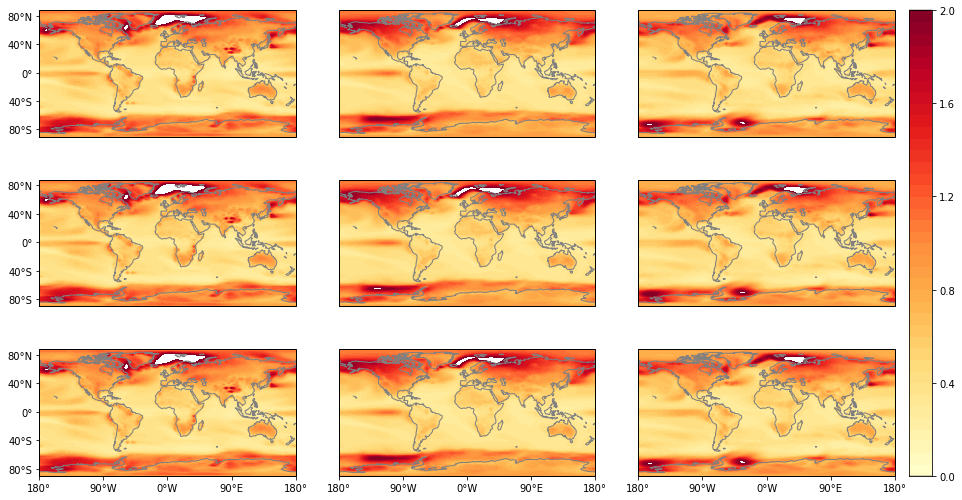

In [158]:
# Plot RMS error

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm


projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.6,
                cbar_location='right',
#               cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior_name']
    tname = cd[ii]['Truth_name']
    prior = cd[ii]['Prior']
    truth = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fp1   = cd[ii]['Filtered truth ensemble using PAGES2k with SNR = 1']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    rmsp = np.sqrt(np.mean((truth-fp1)**2,1))
    
    pldat = rmsp.reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    max
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(0,2.05,.05),
                    transform=projection,
#                    extend='both',
                    cmap='YlOrRd'
                    )
#    axgr.cbar_axes[ii].colorbar(p)
#    plt.title(pname+tname)
#    p.set_clim([-1.2,1.2])
#    plt.colorbar()
#    plt.clim(-1.5,1.5)
    
    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

#fig.savefig('Figs/rmse.pdf', bbox_inches='tight')


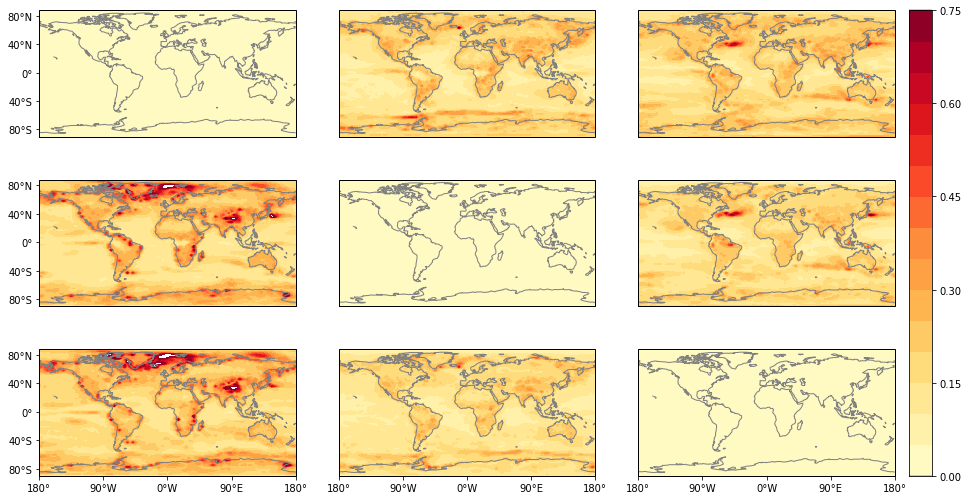

In [7]:
# Plot RMS error

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm


projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.6,
                cbar_location='right',
#               cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior_name']
    tname = cd[ii]['Truth_name']
    prior = cd[ii]['Prior']
    truth = cd[ii]['Truth']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    rmsc = np.sqrt(np.mean((truth-fc)**2,1))
    
    cldat = rmsc.reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    max
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(0,.80,.05),
                    transform=projection,
#                    extend='max',
                    cmap='YlOrRd'
                    )
#    axgr.cbar_axes[ii].colorbar(p)
#    plt.title(pname+tname)
#    p.set_clim([-1.2,1.2])
#    plt.colorbar()
#    plt.clim(-1.5,1.5)
    
    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/rmse_complete_obs.pdf', bbox_inches='tight')


/Users/dan/anaconda2/envs/py27/lib/python2.7/site-packages/numpy/ma/core.py:3169: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


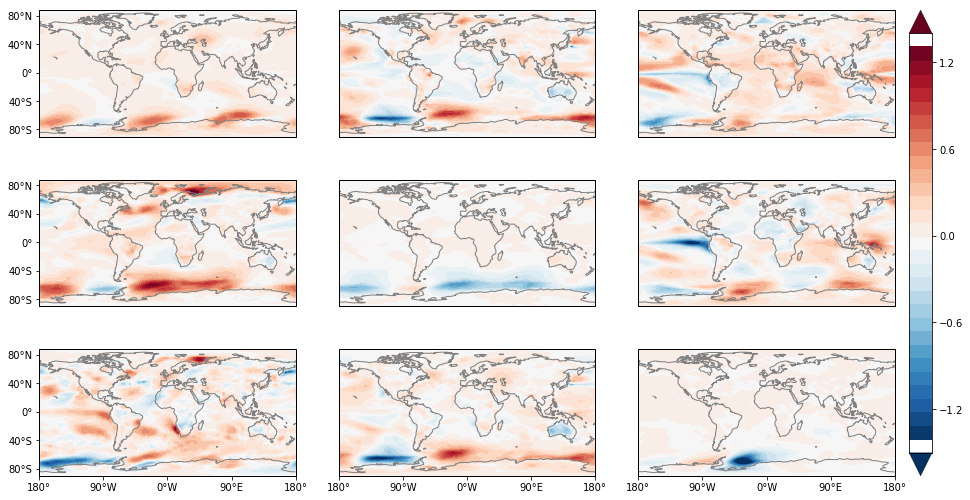

In [8]:
# Plot leading eigenvector of uncertainty for PAGES2k

# index of eigenvector
evecn = 0;

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm


projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.6,
                cbar_location='right',
#                cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior_name']
    tname = cd[ii]['Truth_name']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    pldat = sfp[evecn]**.5*ufp[:,evecn].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-1.5,1.5,.1),
                    transform=projection,
                    extend='both',
                    cmap='RdBu_r'
                    )
    
    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/nullspace_eof1.pdf', bbox_inches='tight')



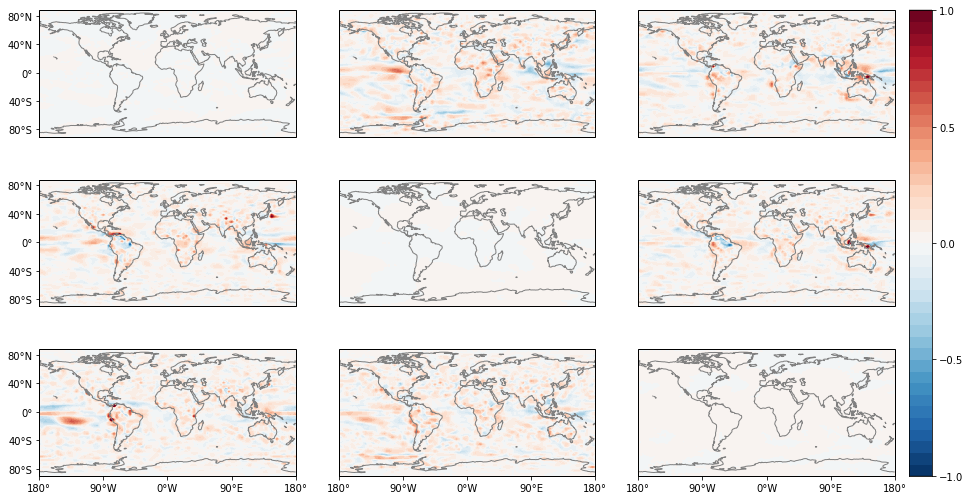

In [9]:
# Plot leading eigenvector of uncertainty for complete obs

# index of eigenvector
evecn = 0;

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm


projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 3),
                axes_pad=0.6,
                cbar_location='right',
#                cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    pname = cd[ii]['Prior_name']
    tname = cd[ii]['Truth_name']
    pi    = cd[ii]['Pind']
    ti    = cd[ii]['Tind']
    fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
    fc    = cd[ii]['Filtered truth ensemble using complete obs']
    ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
    ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
    sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
    sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']


    pldat = sfc[evecn]**.5*ufc[:,evecn].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-1.,1.05,.05),
                    transform=projection,
#                    extend='both',
                    cmap='RdBu_r'
                    )
    
    ax.coastlines(color='gray')
    if pi==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if ti == 0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/nullspace_eof1_complete_obs.pdf', bbox_inches='tight')



In [10]:
# Create a Gaussian blob and plot its resolution
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm

projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

prior = ad[1]['data']
u = np.linalg.svd(prior,full_matrices=False)[0]

MASK  = dmask
L = np.size(dmask)

# Make the H (data) matrix using MASK
H = np.eye(L)[np.ndarray.flatten(MASK,'C'),:]
hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

lla = len(lat_g)
llo = len(lon_g)

gaumat = np.zeros([lla,llo])

# Length scale of the blob
svec = [500,500,3000,3000]
lonvec = [-40,-100,-40,-100]
latvec = [40,0,40,0]
#vminv = [0, -1.e-3]

gau = np.zeros([7008,len(svec)])
resc = np.zeros([7008,len(svec)])
resp = np.zeros([7008,len(svec)])

#toplot = np.zeros([7008,3*len(svec)])

for kk in np.arange(len(svec)):
    print(lonvec[kk])

    for ii in np.arange(lla):
        for jj in np.arange(llo):
            
            s = svec[kk]
            
            dist = haversine(lonvec[kk],latvec[kk],lon_g[jj],lat_g[ii])
            gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))

            gau[:,kk]  = gaumat.ravel('C').T
            resp[:,kk] = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,gau[:,kk]])
            resc[:,kk] = np.linalg.multi_dot([u,u.T,gaumat.ravel('C').T])            
            #toplot[:,2*kk] = gaumat.ravel('C').T
            #toplot[:,2*kk+1] = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,gaumat.ravel('C').T])
            # Filtered truth ensemble using complete data distribution
            #toplot[:,3*kk+2] = np.linalg.multi_dot([u,u.T,gaumat.ravel('C').T])

-40
-100
-40
-100


0
0
0
1
1
1
2
2
2
3
3
3


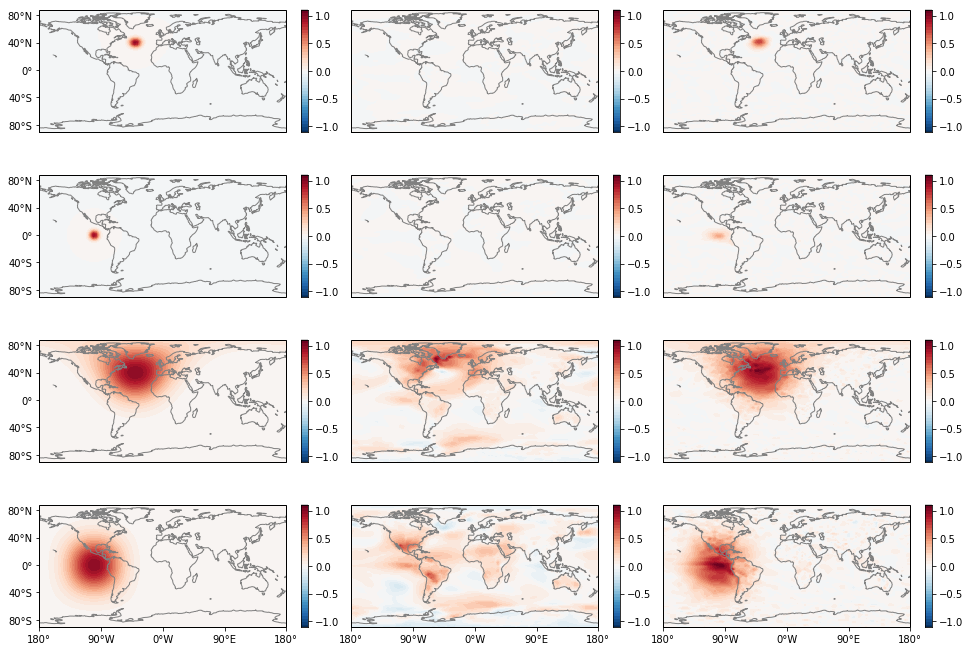

In [11]:
# Set up multi-panel figure to plot Gaussian blobs

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(4, 3),
                axes_pad=0.6,
                cbar_location='right',
               cbar_mode='each',
#                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):
    plt.sca(axgr[ii])
    
    
    nm = np.mod(ii,3)
    ind = ii/3
    print(ind)
    if nm==0:
        pldat = gau[:,ind].reshape(len(lat_g),len(lon_g))
    elif nm==1:
        pldat = resp[:,ind].reshape(len(lat_g),len(lon_g))
    elif nm==2:
        pldat = resc[:,ind].reshape(len(lat_g),len(lon_g))

    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-1.1,1.15,.05),
                    transform=projection,
                    cmap='RdBu_r'
                    )

    cb=axgr.cbar_axes[ii].colorbar(p)
   
    ax.coastlines(color='gray')
    
    if ii>=9:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if np.mod(ii,3)==0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


#cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/Gaussians.pdf', bbox_inches='tight')

-40
-100
-40
-100


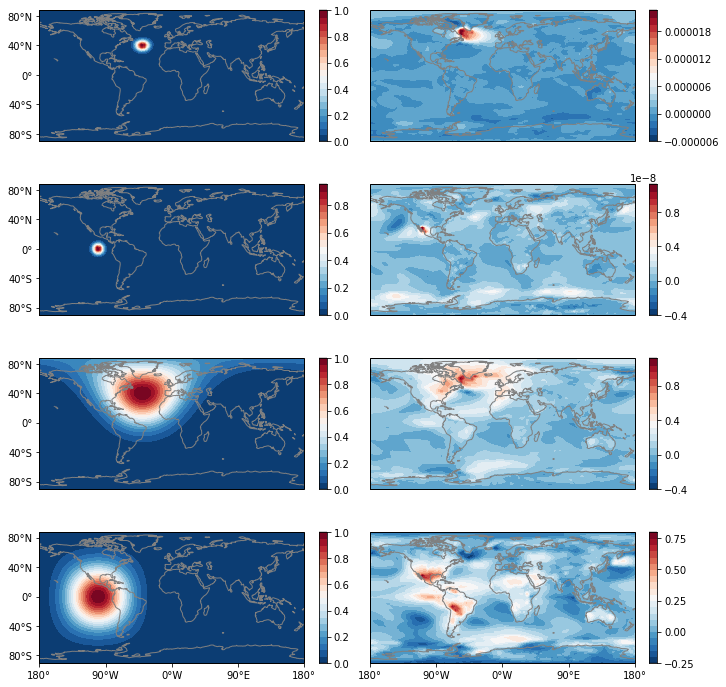

In [12]:
# Create a Gaussian blob and plot its resolution
# Here, only with the PAGES2k network

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm

projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

prior = ad[1]['data']

MASK  = dmask
L = np.size(dmask)

# Make the H (data) matrix using MASK
H = np.eye(L)[np.ndarray.flatten(MASK,'C'),:]
hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

poii = 300

lla = len(lat_g)
llo = len(lon_g)

gaumat = np.zeros([lla,llo])

# Length scale of the blob
svec = [500,500,3000,3000]
lonvec = [-40,-100,-40,-100]
latvec = [40,0,40,0]
vminv = [0, -1.e-3]

gau = np.zeros([7008,len(svec)])
res = np.zeros([7008,len(svec)])

toplot = np.zeros([7008,2*len(svec)])

for kk in np.arange(len(svec)):
    print(lonvec[kk])

    for ii in np.arange(lla):
        for jj in np.arange(llo):
            
            s = svec[kk]
            
            dist = haversine(lonvec[kk],latvec[kk],lon_g[jj],lat_g[ii])
            gaumat[ii,jj] = np.exp(-dist**2./(2.*s**2.))

            #gau[:,kk] = gaumat.ravel('C').T
            #res[:,kk] = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,gaumat.ravel('C').T])
            toplot[:,2*kk] = gaumat.ravel('C').T
            toplot[:,2*kk+1] = np.linalg.multi_dot([prior,prior.T,H.T,hbhi,H,gaumat.ravel('C').T])

# Set up multi-panel figure

fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(4, 2),
                axes_pad=0.6,
                cbar_location='right',
               cbar_mode='each',
#                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):
    plt.sca(axgr[ii])
    pldat = toplot[:,ii].reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    p=plt.contourf(wrap_lon,lat_g,wrap_data,20,#np.arange(-1.,1.,.05),
                    transform=projection,
                    cmap='RdBu_r'
                    )

    cb=axgr.cbar_axes[ii].colorbar(p)
   
    ax.coastlines(color='gray')
    
    if ii>=6:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if np.mod(ii,2)==0:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


#cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/Gaussians.pdf', bbox_inches='tight')




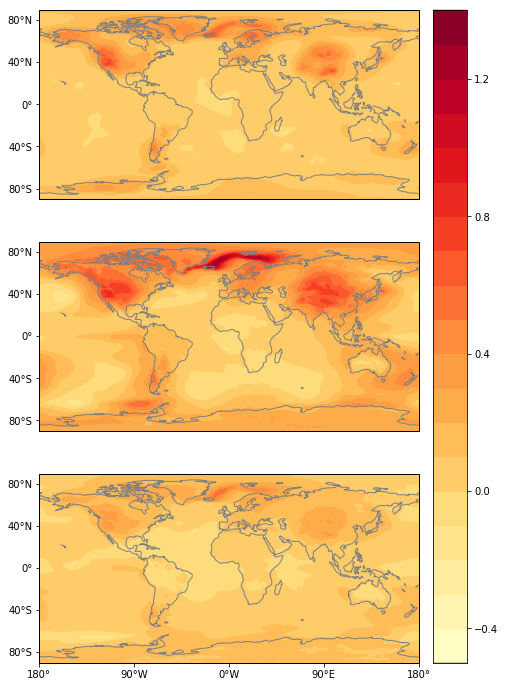

In [13]:
# Plot pointwise resolvability

# For CCSM4
lon_g = np.arange(0,359,1.25)
lat_g = np.arange(-90,90,0.9375)

# array of distances used for pointwise res
#svec = np.array([100, 200, 500, 1000, 2000, 4000, 6000, 8000, 10000, 12000])
# subset I'm using here
svec = np.array([500, 2000, 12000])


fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3,1),
                axes_pad=0.6,
                cbar_location='right',
#               cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    ss = svec[ii]
    Tviis = np.load('resout/Tvii_'+str(ss)+'.npy')
    
    plt.sca(axgr[ii])
    pldat = Tviis.reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon_g, axis=1)

    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-.5,1.5,.1),
                    transform=projection,
                    cmap='YlOrRd'
                    )

    cb=axgr.cbar_axes[ii].colorbar(p)
   
    ax.coastlines(color='gray')
    
    if ii==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if True:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


        


#cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/pointwise.pdf', bbox_inches='tight')



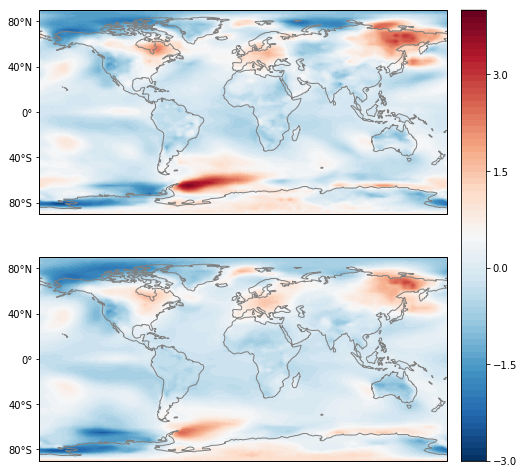

In [14]:
# Plot the resolution for a single year of output from CCSM4

import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm

lon_g = ad[0]['tas_sfc_Amon']['lon']
lat_g = ad[0]['tas_sfc_Amon']['lat']

ii = 4

pname = cd[ii]['Prior_name']
tname = cd[ii]['Truth_name']
prior = cd[ii]['Prior']
truth = cd[ii]['Truth']
pi    = cd[ii]['Pind']
ti    = cd[ii]['Tind']
fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
fc    = cd[ii]['Filtered truth ensemble using complete obs']
ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']

#[Ns,Nt] = prior.shape
#toplot = np.zeros(Ns,3)
toplot = np.concatenate([[truth[:,500]],[fp[:,500]],[fc[:,500]]],axis=0).T

projection = ccrs.PlateCarree(central_longitude=0.)
axes_class = (GeoAxes,
              dict(map_projection=projection))

fig = plt.figure(figsize=(8,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 1),
                axes_pad=0.6,
                cbar_location='right',
#               cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):
    
    tp = toplot[:,ii]
    
    cldat = tp.reshape(len(lat_g),len(lon_g))
    wrap_data, wrap_lon = cutil.add_cyclic_point(cldat, coord=lon_g, axis=1)

    plt.sca(axgr[ii])
    max
    p=plt.contourf(wrap_lon,lat_g,wrap_data,np.arange(-3,4.1,.1),
                    transform=projection,
                    cmap='RdBu_r'
                    )

    ax.coastlines(color='gray')
    if ii==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if True:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)




cb=axgr.cbar_axes[0].colorbar(p)
plt.show()

fig.savefig('Figs/year_1500_CCSM4.pdf', bbox_inches='tight')


In [15]:
from scipy import signal

# Load reanalyis and set it up like model output

# initialize
dd = {}

f = Dataset('./air.mon.mean.nc')

air12 = f.variables['air'][:]
time = f.variables['time']

# Compute annual means

nmon,ny,nx = air12.shape
air = np.ones([nmon/12,ny,nx])*np.NaN

for ii in np.arange(nmon/12):
    si = ii*12
    air[ii,:,:] = np.mean(air12[si:(si+11),:,:],0)
    
# Detrend

airdt = scipy.signal.detrend(air,0)

# Add this to the structure containing model output

y = np.flipud(f.variables['lat'][:])
x = f.variables['lon'][:]
xnew = ad[0]['tas_sfc_Amon']['lon']
ynew = ad[0]['tas_sfc_Amon']['lat']
umhr = np.zeros([ad[0]['data'].shape[0],nmon/12])

for jj in np.arange(nmon/12):
    ft = scipy.interpolate.RectBivariateSpline(y,x,np.flipud(airdt[jj,:,:]))
    umhr[:,jj] = ft(ynew, xnew).ravel()

# Made some changes to get the dimensions consistent but haven't checked that anomalies make sense, so could be an error here!            

dd['model_name'] = 'NCEP reanalysis'
dd['datam'] = umhr
dd['data'] = dd['datam'] - np.tile(np.mean(dd['datam'],0),[max(dd['datam'].shape),1])
dd['lat'] = ad[0]['tas_sfc_Amon']['lat']
dd['lon'] = ad[0]['tas_sfc_Amon']['lon']

# new ad object
adr = ad[:]
adr.append(dd)




In [16]:
# Playing around

# State dim
ns = 100
# number of realizations
R = 1000

dat = np.cumsum(np.random.randn(ns,R),0)

trv = np.zeros(R)*np.NaN
nv =  np.zeros(R)*np.NaN
for Nens in np.arange(1,R):
    sub = dat[:,:Nens]
    u,s,v = np.linalg.svd(sub,full_matrices=False)
    trv[Nens-1] = np.sum(s)
    nv[Nens-1] = Nens
    if np.mod(Nens,100)==0: print(Nens)

100
200
300
400
500
600
700
800
900


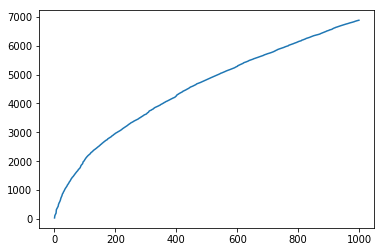

In [17]:
plt.plot(nv,trv)

In [49]:
# Construct regional averages. These were EYEBALLED from the PAGES 2k paper.
# Arctic: >60
# Antarctic: >60
# N America: 30-55 N, 135-75 W
# S America: 66-20 S, 82-37 W
# Europe: 37 - 70 N, 7W - 40 E
# Asia: 23-47 N, 60-165E
# Australasia: 50-0S, 120-180 E

lat = ad[0]['tas_sfc_Amon']['lat']
lon = ad[0]['tas_sfc_Amon']['lon']
lats, lons = np.meshgrid(lat,lon,sparse=False,indexing='ij')
time = np.arange(850,1851)
t = time[1:]

# Mins and maxes defined looking from left to right on the globe
regnames = ['Arctic', 'Antarctic','N America','S America','Europe','Asia','Australasia']
Inf = np.inf
reglatmins = [60, -Inf,30,-66,37,23,-50]
reglatmaxs = [Inf, -60,55,-20,70,47,0]
reglonmins = [-Inf, -Inf,225,278,353,60,120]
reglonmaxs = [Inf, Inf,285,323,40,165,180]

wtmaps = np.tile(np.nan*np.ones(dmask.shape),[len(regnames),1,1])
std_ps = np.nan*np.ones(7)
std_ts = np.nan*np.ones(7)
std_cs = np.nan*np.ones(7)


allmap_std_cs = np.nan*np.ones(dmask.shape)
allmap_std_ts = np.nan*np.ones(dmask.shape)
allmap_std_ps = np.nan*np.ones(dmask.shape)

for jj in np.arange(len(regnames)):

    #fig = plt.figure(figsize=(20,30))
    
    for ii in np.arange(3):#np.arange(9):

        pname = cd[ii]['Prior_name']
        tname = cd[ii]['Truth_name']
        prior = cd[ii]['Prior']
        truth = cd[ii]['Truth']
        pi    = cd[ii]['Pind']
        ti    = cd[ii]['Tind']
        fp    = cd[ii]['Filtered truth ensemble using PAGES2k']
        fc    = cd[ii]['Filtered truth ensemble using complete obs']
        ufp   = cd[ii]['Eigenvectors of nullspace unc using PAGES2k']
        ufc   = cd[ii]['Eigenvectors of nullspace unc using complete obs']
        sfp   = cd[ii]['Eigenvalues of nullspace unc using PAGES2k']
        sfc   = cd[ii]['Eigenvalues of nullspace unc using complete obs']
        uPp   = cd[ii]['Eigenvectors of posterior cov using PAGES2k']
        uPc   = cd[ii]['Eigenvectors of posterior cov using complete obs']
        sPp   = cd[ii]['Eigenvalues of posterior cov using PAGES2k']
        sPc   = cd[ii]['Eigenvalues of posterior cov using complete obs']


        # Construct the mean estimate and its uncertainty.

        # This is the square root of the inverse of the posterior covariance. 
        sqrtPp = np.dot(uPp,np.diag(sPp))
        sqrtPc = np.dot(uPc,np.diag(1/sPc))

        # Define the region
        wtmap = np.nan*np.ones(dmask.shape)
        
        if reglonmins[jj]>reglonmaxs[jj]:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & ((lons>reglonmins[jj]) | (lons<=reglonmaxs[jj]))
        else:
            sh = (lats>reglatmins[jj]) & (lats<=reglatmaxs[jj]) & (lons>reglonmins[jj]) & (lons<=reglonmaxs[jj])
        lwm = np.cos(.5*np.pi*lats[sh]/180)
        #wt1 =  lwm/np.sum(lwm)
        wt1 = lwm
        wtmap[sh] = wt1[:]
        wtmaps[jj,:,:] = wtmap*0+1;

        #sp_reg = sqrtPp[sh.ravel(),:]
        #sc_reg = sqrtPc[sh.ravel(),:]

        # Wunsch 2006 2.413
        #mp =  1/(np.linalg.multi_dot([(wt1.T),sp_reg,sp_reg.T,(wt1)])) * np.linalg.multi_dot([(wt1.T),sp_reg,sp_reg.T,fp[sh.ravel(),:]])
        #pmp = 1/(np.linalg.multi_dot([(wt1.T),sp_reg,sp_reg.T,(wt1)]))

        # Straight "truth" estimate:
        m_st = np.dot(wt1.T/np.sum(wt1),truth[sh.ravel(),:])#

        # Straight "prior" estimate:
        m_sp = np.dot(wt1.T/np.sum(wt1),fp[sh.ravel(),:])
        m_sc = np.dot(wt1.T/np.sum(wt1),fc[sh.ravel(),:])

        #plt.subplot(9,1,ii+1)
        #plt.plot(t,m_st,linewidth=.5,color='black')
        #plt.plot(t,m_sp,linewidth=.5)
        #plt.plot(t,m_sc,linewidth=.5)
        #plt.autoscale(enable=True, axis='x', tight=True)
        ##plt.xlabel('Time (years)')
        #plt.ylabel(regnames[jj]+' anomaly (K)')
        #plt.title('Prior = '+pname+', truth = '+ tname + '. Signal std = '+'%.2f' % np.std(m_st)+ '. Error std = ' + '%.2f' % np.std(m_sp-m_st) + 'K (PAGES 2k obs), '+ '%.2f' % np.std(m_sc-m_st) + 'K (complete obs)')

        std_cs[jj] = np.std(m_sc-m_st)
        std_ts[jj] = np.std(m_st)
        std_ps[jj] = np.std(m_sp-m_st)
        
        allmap_std_cs[~np.isnan(wtmap)] = std_cs[jj]
        allmap_std_ts[~np.isnan(wtmap)] = std_ts[jj]
        allmap_std_ps[~np.isnan(wtmap)] = std_ps[jj]
        
    #plt.matshow(wtmap)
    #plt.show()
        
#    fig.savefig('Figs/reg_averages_'+regnames[jj],format='pdf')


# Stack errors into single plots


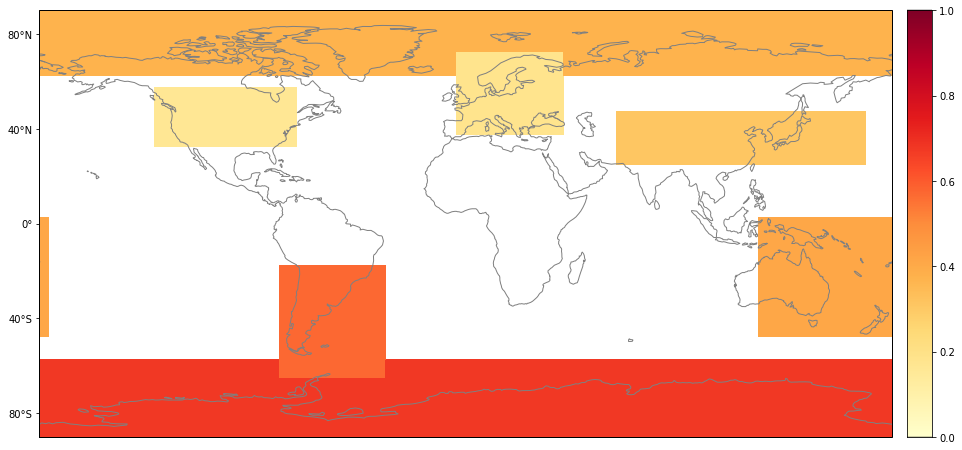

In [177]:
# Plot cont'l errors

# For CCSM4
#lon_g = np.arange(0,359,1.25)
#lat_g = np.arange(-90,90,0.9375)

# array of distances used for pointwise res
#svec = np.array([100, 200, 500, 1000, 2000, 4000, 6000, 8000, 10000, 12000])
# subset I'm using here
svec = np.array([500, 2000, 12000])


fig = plt.figure(figsize=(16,12))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=0.6,
                cbar_location='right',
#               cbar_mode='each',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='3%',
                cbar_set_cax=False,
                label_mode='')  # note the empty label_mode

for ii, ax in enumerate(axgr):

    plt.sca(axgr[ii])
    pldat = allmap_std_ps/allmap_std_ts
    wrap_data, wrap_lon = cutil.add_cyclic_point(pldat, coord=lon, axis=1)

    p=plt.pcolor(wrap_lon,lat,wrap_data,
                    transform=projection,
                    cmap='YlOrRd',vmin=0,vmax=1.
                    )

    cb=axgr.cbar_axes[ii].colorbar(p)
   
    ax.coastlines(color='gray')
    
    if ii==2:
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(np.linspace(-180, 180, 5), crs=projection)
    
    if True:
        ax.set_yticks(np.linspace(-80, 80, 5), crs=projection)
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)


        


#cb=axgr.cbar_axes[0].colorbar(p)
plt.show()


In [206]:
# AMOC
data_vars  = {'AMOC26N1000m_Omon':0}
data_file  = 'AMOC26N1000m_Omon_CCSM4_past1000_085001-185012.nc'
ccsm4_amoc_obj = read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
amoc_c = ccsm4_amoc_obj['AMOC26N1000m_Omon']['value']

data_vars  = {'AMOC26N1000m_Omon':0}
data_file  = 'MPI/AMOC26N1000m_Omon_MPI-ESM-P_past1000_085001-185012.nc'
mpi_amoc_obj = read_gridded_data_CMIP5_model(data_dir,data_file,data_vars,outtimeavg,detrend=None)
amoc_m = mpi_amoc_obj['AMOC26N1000m_Omon']['value']

amocs = [[],amoc_c[:ny],amoc_m[:ny]]

Reading file:  /Users/dan/Desktop/CCSM4_ctrl//AMOC26N1000m_Omon_CCSM4_past1000_085001-185012.nc
(12012,)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
AMOC26N1000m : Global(monthly): mean= 1.5243545516983017e-07  , std-dev= 1758557074.2350616
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
AMOC26N1000m : Global(time-averaged): mean= 1.5243545516983017e-07  , std-dev= 850945638.547033
Reading file:  /Users/dan/Desktop/CCSM4_ctrl//MPI/AMOC26N1000m_Omon_MPI-ESM-P_past1000_085001-185012.nc
(12000,)
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
AMOC26N1000m : Global(monthly): mean= -4.6793619791666664e-07  , std-dev= 2837365651.579172
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
AMOC26N1000m : Global(time-averaged): mean= -4.730224609375e-07  , std-dev= 1266420953.768891


CCSM4
CCSM4


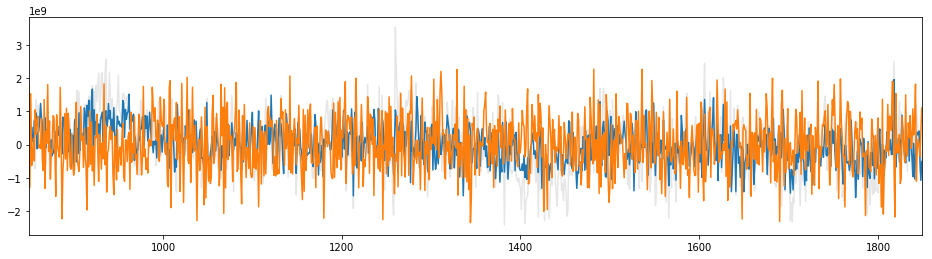

CCSM4
MPI-ESM


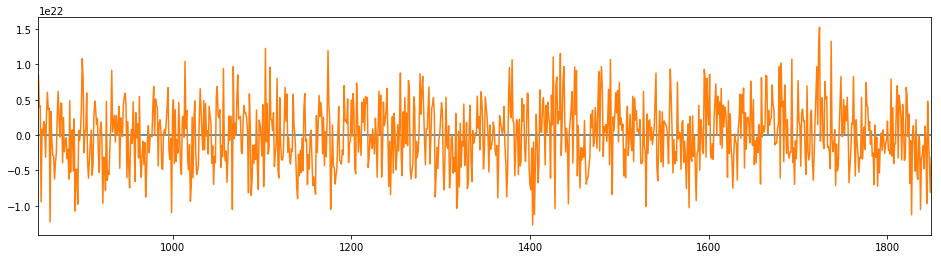

MPI-ESM
CCSM4


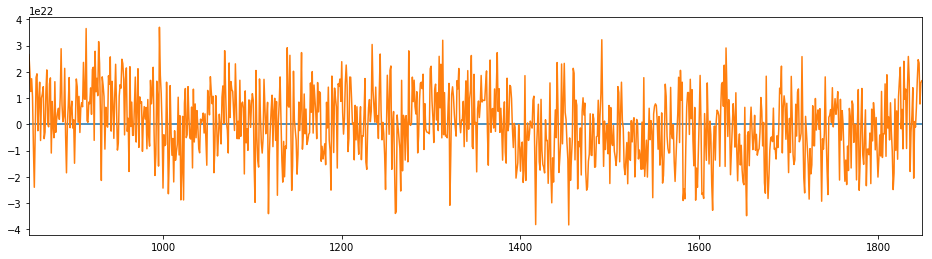

MPI-ESM
MPI-ESM


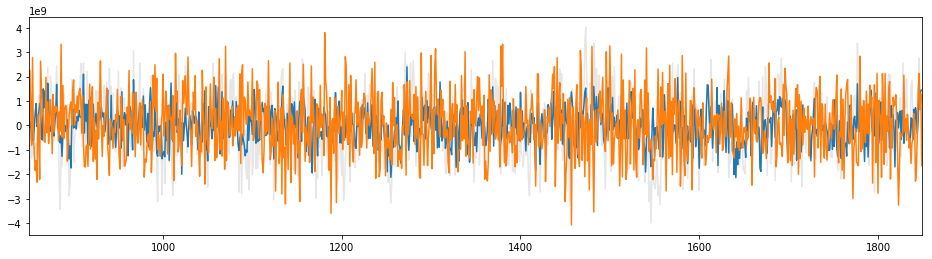

In [286]:
# Compare what happens for AMOC in various truth-prior pairs

import wd; reload(wd)

# Array of dictionaries containing the different comparisons
cda = []

L = np.size(Gn)

# Make a vector of 
inds = np.arange(Gn.shape[0]*Gn.shape[1])
list = []

lt = []
for ii in inds[Gn.ravel()!=0]:
    lt = np.concatenate([lt,ii*np.ones(Gn.ravel()[ii].astype(int))]).astype(int)

H = np.eye(L)[lt,:]

rpt_p2k = np.zeros([Ldf,Ldf,L,1000])
rpt_all = np.zeros([Ldf,Ldf,L,1000])

for ii in np.array([1,2]):
    prior = ad[ii]['data']
    prior_amoc = amocs[ii]
    
    # No noise case    
    hbhi = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)),rcond=1 )

    # SNR = 1 case
    # Generate vector of error standard deviations based on a fixed SNR
    SNR = 1.
    globalStds = np.std(prior,1).ravel()
    sigs = globalStds[lt]*1./SNR
    hbhi_1 = scipy.linalg.pinv( H.dot(prior).dot(prior.T.dot(H.T)) + np.diag(sigs**2),rcond=1 )

    # For a complete observing system, it's BB^{-1}. I want to save this i.t.o. its factors. 
    # Probably easiest to do with SVD. 
    # Just UU.T
    u,s,v = np.linalg.svd(prior,full_matrices=False)

    for jj in np.array([1,2]):

        truth = ad[jj]['data']
        truth_amoc = amocs[ii]
        
        # These "filtered truth" variables are the posterior estimate.
        # Filtered truth ensemble using PAGES2k data distribution
        fp = np.linalg.multi_dot([prior_amoc,prior.T,H.T,hbhi,H,truth])

        # Filtered truth ensemble using PAGES2k data distribution and SNR = 1
        fp_1 = np.linalg.multi_dot([prior_amoc,prior.T,H.T,hbhi_1,H,truth])
        
        # With complete observations
        fc = np.linalg.multi_dot([prior_amoc,v,np.diag(1/s),u.T,truth])
        
        print(model_names[ii])
        print(model_names[jj])
        
        # Store this information in a dictionary
        ca = {}
        ca['Prior_name'] = model_names[ii]
        ca['Pind'] = ii
        ca['Truth_name'] = model_names[jj]
        ca['Tind'] = jj
        ca['Truth'] = truth_amoc
        ca['Prior'] = prior_amoc
        ca['Filtered truth ensemble using complete obs'] = fc
        ca['Filtered truth ensemble using PAGES2k'] = fp
        ca['Filtered truth ensemble using PAGES2k with SNR = 1'] = fp_1

        # Concatenate the dictionary to a list corresponding to all prior-truth pairs
        cda.append(ca)
        
        fig = plt.figure(figsize=(16,4))
        plt.plot(time[:ny],truth_amoc,color=[.9, .9, .9])
        plt.plot(time[:ny],fp)
        plt.plot(time[:ny],fc)
        #plt.plot(fp_1)
        plt.autoscale(enable=True,axis='x',tight=True)
        plt.show();

In [ ]:
# Plot AMOC



ii = 1

pname = cda[ii]['Prior_name']
tname = cda[ii]['Truth_name']
prior = cda[ii]['Prior']
truth = cda[ii]['Truth']
pi    = cda[ii]['Pind']
ti    = cda[ii]['Tind']
fp    = cda[ii]['Filtered truth ensemble using PAGES2k']
fc    = cda[ii]['Filtered truth ensemble using complete obs']
